In [1]:
import zipfile
import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn import cross_validation

/Users/yingzhu/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [39]:
df = pd.read_csv('/Users/yingzhu/Desktop/FlightDely_201401_201708.csv',header=0)
df = df[df['ORIGIN']=='JFK']

In [40]:
df["Flight_Num"] = df["UNIQUE_CARRIER"].map(str) + df["FL_NUM"].map(str)

In [41]:
df = df[['YEAR','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','UNIQUE_CARRIER','CRS_DEP_TIME','DEST','DEP_DELAY','Flight_Num']]

In [42]:
df = df[np.isfinite(df['DEP_DELAY'])]

In [43]:
Carrier_list = list(df['UNIQUE_CARRIER'].unique())
Dest_list = list(df['DEST'].unique())

In [44]:
def carrier_mean(df,carrier_name,col_name):
    cur_carrier = df[df[col_name]==carrier_name]
    carrier_mean = np.mean(cur_carrier['DEP_DELAY'])
    return carrier_mean

In [45]:
def cal_mean(df,carrier_list,col_name):
    Carrier_mean ={}
    for i in carrier_list:
        Carrier_mean[i]=carrier_mean(df,i,col_name)
    return Carrier_mean

In [46]:
car_mean = cal_mean(df,Carrier_list,'UNIQUE_CARRIER')
df["Carrier_Mean"] = df["UNIQUE_CARRIER"].map(car_mean)
dest_mean = cal_mean(df,Dest_list,'DEST')
df["Dest_Mean"] = df["DEST"].map(dest_mean)

In [30]:
df.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,CRS_DEP_TIME,DEST,DEP_DELAY,Flight_Num,Carrier_Mean,Dest_Mean
163,2014,1,1,3,MQ,1930,CMH,-1.0,MQ3535,11.079078,12.654429
165,2014,1,3,5,MQ,1930,CMH,66.0,MQ3535,11.079078,12.654429
166,2014,1,4,6,MQ,1930,CMH,4.0,MQ3535,11.079078,12.654429
167,2014,1,5,7,MQ,1930,CMH,29.0,MQ3535,11.079078,12.654429
168,2014,1,6,1,MQ,1930,CMH,143.0,MQ3535,11.079078,12.654429


In [47]:
df.CRS_DEP_TIME = pd.cut(df.CRS_DEP_TIME, range(0,2600,100),labels=range(0,25))
#df.DEP_DELAY = pd.qcut(df.DEP_DELAY, 5, labels=[1,2,3,4,5])
df['DEP_DELAY'] = np.where(df['DEP_DELAY']>=0, 1, 0)

In [32]:
df.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,CRS_DEP_TIME,DEST,DEP_DELAY,Flight_Num,Carrier_Mean,Dest_Mean
163,2014,1,1,3,MQ,19,CMH,0,MQ3535,11.079078,12.654429
165,2014,1,3,5,MQ,19,CMH,1,MQ3535,11.079078,12.654429
166,2014,1,4,6,MQ,19,CMH,0,MQ3535,11.079078,12.654429
167,2014,1,5,7,MQ,19,CMH,1,MQ3535,11.079078,12.654429
168,2014,1,6,1,MQ,19,CMH,1,MQ3535,11.079078,12.654429


In [48]:
def one_hot_encoding(df,list):
    map={}
    for i in range(len(list)):
        map[list[i]]= i 
    return map
df['DEST'] = df['DEST'].map(one_hot_encoding(df,Dest_list))
df['UNIQUE_CARRIER'] = df['UNIQUE_CARRIER'].map(one_hot_encoding(df,Carrier_list))

In [49]:
df = df.drop(['Flight_Num'],axis=1)

In [50]:
# seperate dependent variables and independent variables
X = df.loc[:,df.columns != 'DEP_DELAY'].values
Y = list(df.loc[:,'DEP_DELAY'].values)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .3,random_state =0)
LogReg = LogisticRegression(class_weight='balanced')
logistic_scores = cross_validation.cross_val_score(LogReg,X_train,y_train,cv=3)
print ("Logistic average accuracy: ", np.mean(logistic_scores))
print (logistic_scores)

Logistic average accuracy:  0.612005918471
[ 0.61025954  0.61167883  0.61407938]


In [62]:
LogReg.fit(X_train, y_train)
test_predict = LogReg.predict_proba(X_test)[:,1]

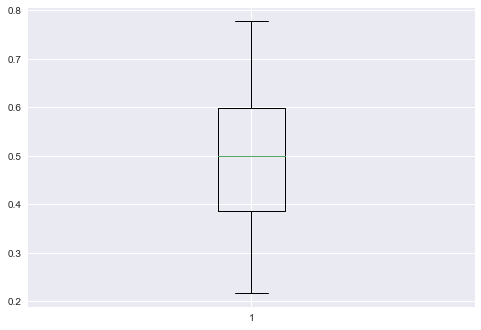

In [65]:
plt.boxplot(test_predict)
plt.show()

In [52]:
from sklearn.metrics import confusion_matrix
result = LogReg.fit(X_train,y_train)
y_pred = LogReg.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.67      0.60      0.63     60193
          1       0.55      0.62      0.58     47255

avg / total       0.62      0.61      0.61    107448



In [53]:
df.DEP_DELAY.value_counts()

0    199889
1    158269
Name: DEP_DELAY, dtype: int64